Iterate through the sessions and use them for reference. For each reference remove most neurons, find the PCs and decode the removed neurons from the PCs. Decode from the aligned PCs of all the other session the neurons kept out.

In [1]:
import os

parent_directory = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
grandparent_directory = os.path.abspath(os.path.join(parent_directory, os.pardir))
os.sys.path.append(grandparent_directory)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from scipy.stats import pearsonr
import pickle as pkl
from sklearn import linear_model  # Loss: least squares, regularization: L2
from sklearn.multioutput import MultiOutputRegressor

from tools.data_formatting import (
    get_smoothed_moving_all_data,
    get_common_indexes_n_recordings,
    smooth_tuning_curves_circularly,
    from_local_to_global_index,
)
from tools.data_manager import get_all_experiments_runs, get_fovs_given_animal
from tools.alignment import procrustes, canoncorr
from params import (
    order_experiments,
    get_colors_for_each_experiment,
    animals,
    root_dir,
    experiments_to_exclude,
)

from functions import (
    get_predicted_tuning_curves_one_out,
    get_predicted_tuning_curves_common_out,
)


# Load the data

In [2]:
### Load all sessions ###

animal = "m135"
fov = "fov1"
sessions = get_all_experiments_runs(animal, fov)
# Remove sessions to exclude
sessions = [session for session in sessions if session not in experiments_to_exclude]
# Create a mapping of sessions and their chronological order
order_map = {value: index for index, value in enumerate(order_experiments)}
sessions = sorted(sessions, key=lambda x: order_map[x])

# Load the cells with the global index and the tuning curves
all_cells = []
all_tuning_curves = []
for experiment, run in sessions:
    _, _, phi, cells, tuning_curves, _ = get_smoothed_moving_all_data(
        animal, fov, experiment, run
    )
    cells = from_local_to_global_index(animal, fov, (experiment, run), cells)
    all_cells.append(cells)
    all_tuning_curves.append(tuning_curves)

pc_components = 20
n_neurons_to_keep = 40

# Use one reference session and align the whole target session PCA to it. Decode the ref session tuning curves kept out, by using its PCs

In [3]:
# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 20)
    for tuning_curves in all_tuning_curves
]

results_pca = {}

for ref in range(len(sessions)):
    print(f"Processing reference session {ref + 1}/{len(sessions)}")
    ref_tc = smoothed_tuning_curves[ref]
    results_pca[sessions[ref]] = {}
    pca = PCA(n_components=pc_components)
    for i in range(len(sessions)):
        # Don't want to align the reference to itself
        if i == ref:
            continue
        results_pca[sessions[ref]][sessions[i]] = {}
        target_tc = smoothed_tuning_curves[i]
        # Remove randomly tuning curves
        idxs_to_keep = np.random.choice(
            np.arange(ref_tc.shape[1]), n_neurons_to_keep, replace=False
        )
        sel_ref_tc = ref_tc[:, idxs_to_keep]
        removed_tc = np.delete(ref_tc, idxs_to_keep, axis=1)
        # Find the PCs of ref and target
        pca_sel_ref = pca.fit_transform(sel_ref_tc)
        pca_target = pca.fit_transform(target_tc)
        # Align the tuning curves
        A, B, _, _, _ = canoncorr(pca_sel_ref, pca_target, fullReturn=True)
        proj_target_cca = pca_target @ B @ np.linalg.inv(A)
        # Make a decoder to predict the tuning curves kept out
        model = MultiOutputRegressor(linear_model.LinearRegression())
        model.fit(pca_sel_ref, removed_tc)
        predicted_tc = model.predict(pca_sel_ref)
        predicted_aligned_tc = model.predict(proj_target_cca)
        # Store the results
        results_pca[sessions[ref]][sessions[i]]["removed_tc"] = removed_tc
        results_pca[sessions[ref]][sessions[i]]["predicted_tc"] = predicted_tc
        results_pca[sessions[ref]][sessions[i]]["predicted_aligned_tc"] = (
            predicted_aligned_tc
        )

Processing reference session 1/9
Processing reference session 2/9
Processing reference session 3/9
Processing reference session 4/9
Processing reference session 5/9
Processing reference session 6/9
Processing reference session 7/9
Processing reference session 8/9
Processing reference session 9/9


/var/folders/vh/pvb88dx50v11x630t4hkqcpr0000gq/T/ipykernel_60777/1555077933.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)
/var/folders/vh/pvb88dx50v11x630t4hkqcpr0000gq/T/ipykernel_60777/1555077933.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)


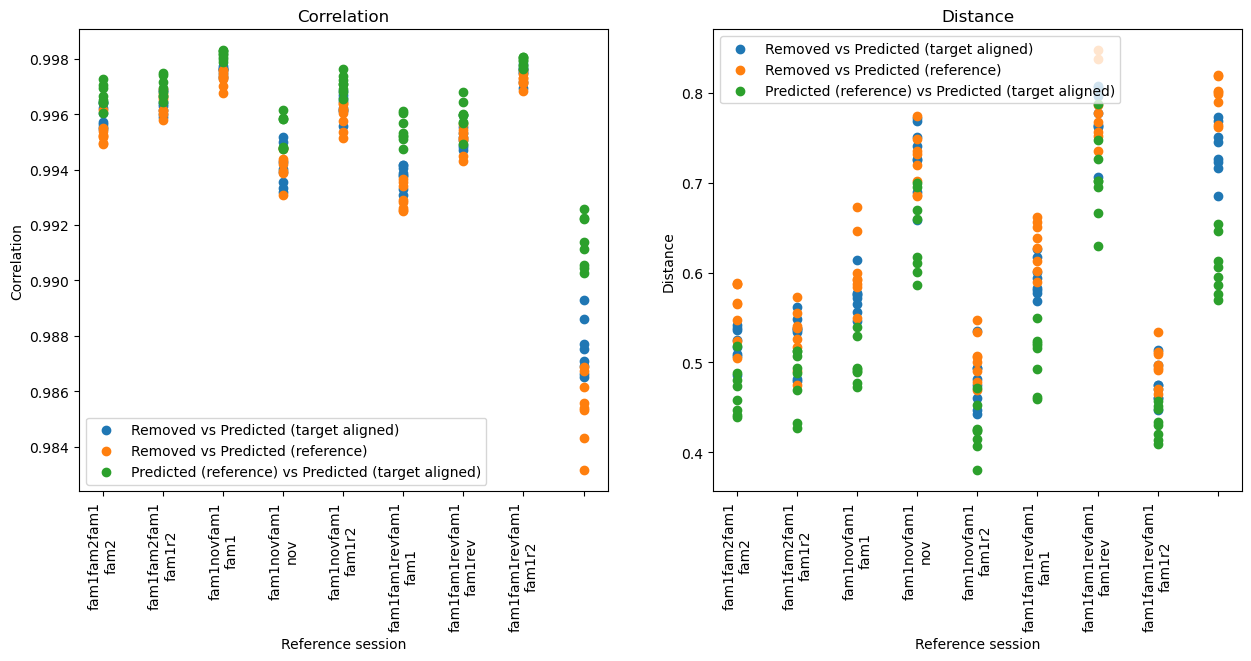

In [4]:
# Find correlations of the results
corr_removed_predicted, corr_removed_predicted_aligned, corr_pred_predicted_aligned = (
    [],
    [],
    [],
)
dist_removed_predicted, dist_removed_predicted_aligned, dist_pred_predicted_aligned = (
    [],
    [],
    [],
)
ref_sessions, s = [], 0
for ref in results_pca:
    for target in results_pca[ref]:
        removed_tc = results_pca[ref][target]["removed_tc"]
        predicted_tc = results_pca[ref][target]["predicted_tc"]
        predicted_aligned_tc = results_pca[ref][target]["predicted_aligned_tc"]
        # Remove flat tuning curves
        idxs_to_remove = []
        for n in range(removed_tc.shape[1]):
            if (
                np.all(removed_tc[:, n] == removed_tc[0, n])
                or (np.all(predicted_tc[:, n] == predicted_tc[0, n]))
                or (np.all(predicted_aligned_tc[:, n] == predicted_aligned_tc[0, n]))
            ):
                idxs_to_remove.append(n)
        if len(idxs_to_remove) > 0:
            removed_tc = np.delete(removed_tc, idxs_to_remove, axis=1)
            predicted_tc = np.delete(predicted_tc, idxs_to_remove, axis=1)
            predicted_aligned_tc = np.delete(
                predicted_aligned_tc, idxs_to_remove, axis=1
            )
        # Calculate the correlation between the removed and predicted tuning curves
        corr_removed_predicted.append(
            pearsonr(removed_tc.T.flatten(), predicted_tc.T.flatten())[0]
        )
        corr_removed_predicted_aligned.append(
            pearsonr(removed_tc.T.flatten(), predicted_aligned_tc.T.flatten())[0]
        )
        corr_pred_predicted_aligned.append(
            pearsonr(predicted_tc.T.flatten(), predicted_aligned_tc.T.flatten())[0]
        )
        # Calculate the distance between the removed and predicted tuning curves
        dist_removed_predicted.append(
            np.linalg.norm(removed_tc.T.flatten() - predicted_tc.T.flatten())
        )
        dist_removed_predicted_aligned.append(
            np.linalg.norm(removed_tc.T.flatten() - predicted_aligned_tc.T.flatten())
        )
        dist_pred_predicted_aligned.append(
            np.linalg.norm(predicted_tc.T.flatten() - predicted_aligned_tc.T.flatten())
        )
        ref_sessions.append(s)
    s += 1

### Use to compare ###
pca_corr_removed_predicted_aligned = np.copy(corr_removed_predicted_aligned)
pca_dist_removed_predicted_aligned = np.copy(dist_removed_predicted_aligned)

# Plot in one scatter plot
fig = plt.figure(figsize=(15, 6))
grid = plt.GridSpec(nrows=1, ncols=2, figure=fig)

# CORRELATION
ax = fig.add_subplot(grid[0])
ax.set_title("Correlation")
ax.scatter(
    ref_sessions,
    corr_removed_predicted_aligned,
    label="Removed vs Predicted (target aligned)",
)
ax.scatter(
    ref_sessions, corr_removed_predicted, label="Removed vs Predicted (reference)"
)
ax.scatter(
    ref_sessions,
    corr_pred_predicted_aligned,
    label="Predicted (reference) vs Predicted (target aligned)",
)
ax.set_xlabel("Reference session")
ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)
ax.set_ylabel("Correlation")
ax.legend()

# DISTANCE
ax = fig.add_subplot(grid[1])
ax.set_title("Distance")
ax.scatter(
    ref_sessions,
    dist_removed_predicted_aligned,
    label="Removed vs Predicted (target aligned)",
)
ax.scatter(
    ref_sessions, 
    dist_removed_predicted, 
    label="Removed vs Predicted (reference)"
)
ax.scatter(
    ref_sessions,
    dist_pred_predicted_aligned,
    label="Predicted (reference) vs Predicted (target aligned)",
)
ax.set_xlabel("Reference session")
ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)
ax.set_ylabel("Distance")
ax.legend()

plt.show()

# Do the same thing as before but decode from the neurons and not the PCs

In [5]:
# Smooth the tuning curves very little for better alignment
smoothed_tuning_curves = [
    smooth_tuning_curves_circularly(tuning_curves, 20)
    for tuning_curves in all_tuning_curves
]
results_neu = {}

for ref in range(len(sessions)):
    print(f"Processing reference session {ref + 1}/{len(sessions)}")
    ref_tc = smoothed_tuning_curves[ref]
    results_neu[sessions[ref]] = {}
    pca = PCA(n_components=pc_components)
    for i in range(len(sessions)):
        # Don't want to align the reference to itself
        if i == ref:
            continue
        results_neu[sessions[ref]][sessions[i]] = {}
        target_tc = smoothed_tuning_curves[i]
        # Remove randomly tuning curves
        idxs_to_keep = np.random.choice(
            np.arange(ref_tc.shape[1]), n_neurons_to_keep, replace=False
        )
        sel_ref_tc = ref_tc[:, idxs_to_keep]
        removed_tc = np.delete(ref_tc, idxs_to_keep, axis=1)
        # Find the PCs of ref and target
        mean_ref = np.mean(sel_ref_tc, axis=0)
        pca_sel_ref = pca.fit_transform(sel_ref_tc)
        components_ref = pca.components_.T
        pca_target = pca.fit_transform(target_tc)
        # Align the tuning curves
        A, B, _, _, _ = canoncorr(pca_sel_ref, pca_target, fullReturn=True)
        # project on the neural space
        proj_target_neural = (
            pca_target @ B @ np.linalg.inv(A)
        ) @ components_ref.T + mean_ref
        # Make a decoder to predict the tuning curves kept out
        model = MultiOutputRegressor(linear_model.LinearRegression())
        model.fit(sel_ref_tc, removed_tc)
        predicted_tc = model.predict(sel_ref_tc)
        predicted_aligned_tc = model.predict(proj_target_neural)
        # Store the results
        results_neu[sessions[ref]][sessions[i]]["removed_tc"] = removed_tc
        results_neu[sessions[ref]][sessions[i]]["predicted_tc"] = predicted_tc
        results_neu[sessions[ref]][sessions[i]]["predicted_aligned_tc"] = (
            predicted_aligned_tc
        )

Processing reference session 1/9
Processing reference session 2/9
Processing reference session 3/9
Processing reference session 4/9
Processing reference session 5/9
Processing reference session 6/9
Processing reference session 7/9
Processing reference session 8/9
Processing reference session 9/9


/var/folders/vh/pvb88dx50v11x630t4hkqcpr0000gq/T/ipykernel_60777/4044066635.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)
/var/folders/vh/pvb88dx50v11x630t4hkqcpr0000gq/T/ipykernel_60777/4044066635.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)


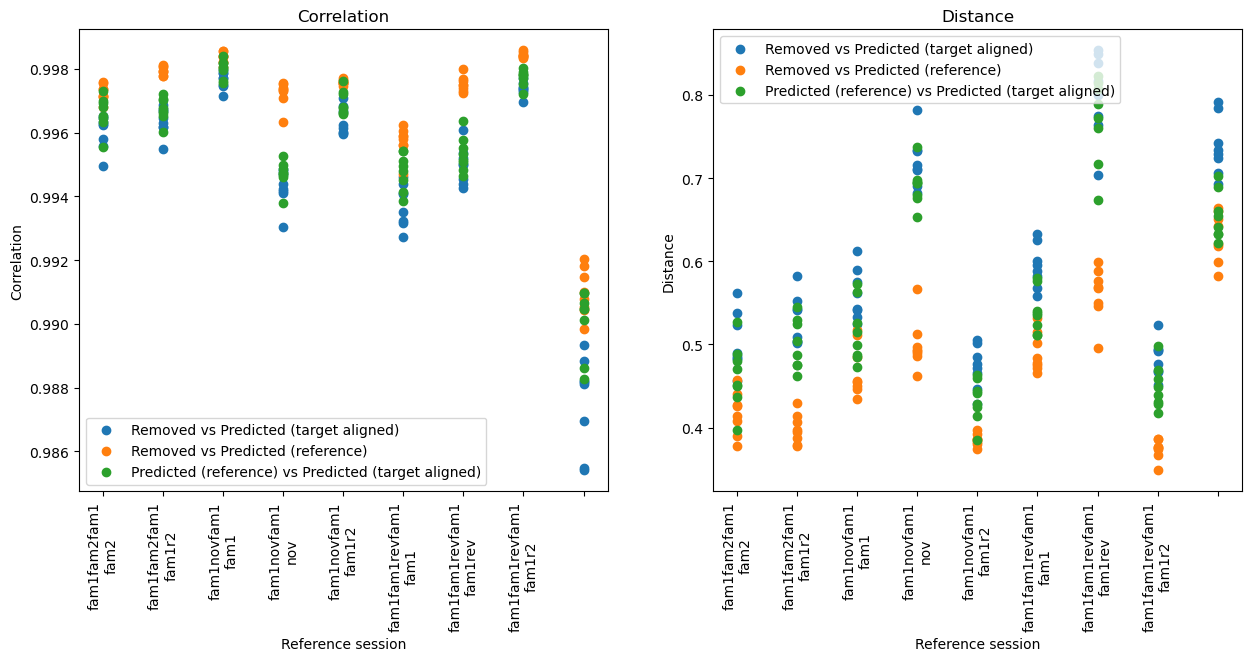

In [6]:
# Find correlations of the results
corr_removed_predicted, corr_removed_predicted_aligned, corr_pred_predicted_aligned = (
    [],
    [],
    [],
)
dist_removed_predicted, dist_removed_predicted_aligned, dist_pred_predicted_aligned = (
    [],
    [],
    [],
)
ref_sessions, s = [], 0
for ref in results_neu:
    for target in results_neu[ref]:
        removed_tc = results_neu[ref][target]["removed_tc"]
        predicted_tc = results_neu[ref][target]["predicted_tc"]
        predicted_aligned_tc = results_neu[ref][target]["predicted_aligned_tc"]
        # Remove flat tuning curves
        idxs_to_remove = []
        for n in range(removed_tc.shape[1]):
            if (
                np.all(removed_tc[:, n] == removed_tc[0, n])
                or (np.all(predicted_tc[:, n] == predicted_tc[0, n]))
                or (np.all(predicted_aligned_tc[:, n] == predicted_aligned_tc[0, n]))
            ):
                idxs_to_remove.append(n)
        if len(idxs_to_remove) > 0:
            removed_tc = np.delete(removed_tc, idxs_to_remove, axis=1)
            predicted_tc = np.delete(predicted_tc, idxs_to_remove, axis=1)
            predicted_aligned_tc = np.delete(
                predicted_aligned_tc, idxs_to_remove, axis=1
            )
        # Calculate the correlation between the removed and predicted tuning curves
        corr_removed_predicted.append(
            pearsonr(removed_tc.T.flatten(), predicted_tc.T.flatten())[0]
        )
        corr_removed_predicted_aligned.append(
            pearsonr(removed_tc.T.flatten(), predicted_aligned_tc.T.flatten())[0]
        )
        corr_pred_predicted_aligned.append(
            pearsonr(predicted_tc.T.flatten(), predicted_aligned_tc.T.flatten())[0]
        )
        # Calculate the distance between the removed and predicted tuning curves
        dist_removed_predicted.append(
            np.linalg.norm(removed_tc.T.flatten() - predicted_tc.T.flatten())
        )
        dist_removed_predicted_aligned.append(
            np.linalg.norm(removed_tc.T.flatten() - predicted_aligned_tc.T.flatten())
        )
        dist_pred_predicted_aligned.append(
            np.linalg.norm(predicted_tc.T.flatten() - predicted_aligned_tc.T.flatten())
        )
        ref_sessions.append(s)
    s += 1

### Use to compare ###
neu_corr_removed_predicted_aligned = np.copy(corr_removed_predicted_aligned)
neu_dist_removed_predicted_aligned = np.copy(dist_removed_predicted_aligned)

# Plot in one scatter plot
fig = plt.figure(figsize=(15, 6))
grid = plt.GridSpec(nrows=1, ncols=2, figure=fig)

# CORRELATION
ax = fig.add_subplot(grid[0])
ax.set_title("Correlation")
ax.scatter(
    ref_sessions,
    corr_removed_predicted_aligned,
    label="Removed vs Predicted (target aligned)",
)
ax.scatter(
    ref_sessions, corr_removed_predicted, label="Removed vs Predicted (reference)"
)
ax.scatter(
    ref_sessions,
    corr_pred_predicted_aligned,
    label="Predicted (reference) vs Predicted (target aligned)",
)
ax.set_xlabel("Reference session")
ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)
ax.set_ylabel("Correlation")
ax.legend()

# DISTANCE
ax = fig.add_subplot(grid[1])
ax.set_title("Distance")
ax.scatter(
    ref_sessions,
    dist_removed_predicted_aligned,
    label="Removed vs Predicted (target aligned)",
)
ax.scatter(
    ref_sessions, 
    dist_removed_predicted, 
    label="Removed vs Predicted (reference)"
)
ax.scatter(
    ref_sessions,
    dist_pred_predicted_aligned,
    label="Predicted (reference) vs Predicted (target aligned)",
)
ax.set_xlabel("Reference session")
ax.set_xticklabels([f"{s[0]}\n{s[1]}" for s in sessions], rotation=90)
ax.set_ylabel("Distance")
ax.legend()

plt.show()

# Plot together the neurons and the PCA

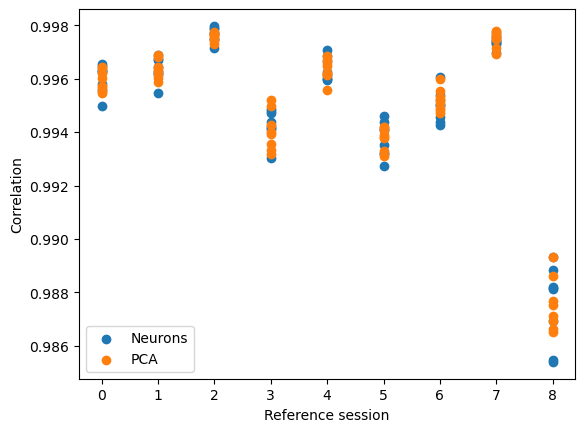

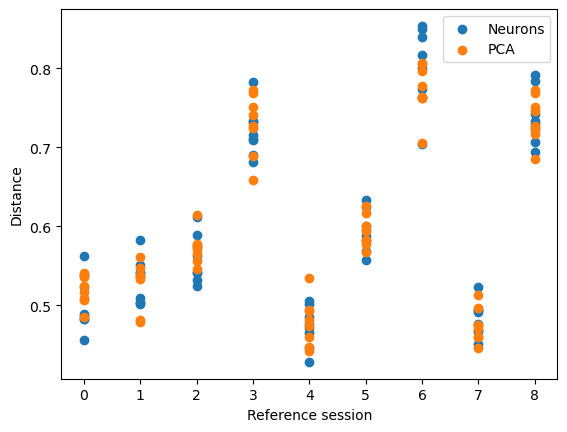

In [7]:
plt.scatter(ref_sessions, neu_corr_removed_predicted_aligned, label='Neurons')
plt.scatter(ref_sessions, pca_corr_removed_predicted_aligned, label='PCA')
plt.xlabel("Reference session")
plt.ylabel("Correlation")
plt.legend()
plt.show()

plt.scatter(ref_sessions, neu_dist_removed_predicted_aligned, label='Neurons')
plt.scatter(ref_sessions, pca_dist_removed_predicted_aligned, label='PCA')
plt.xlabel("Reference session")
plt.ylabel("Distance")
plt.legend()
plt.show()

In [8]:
# TODO: make same number of neurons and components